In [4]:
import torch
from torch import nn
import torchvision.datasets as datasets 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from model import *

Download/loading the dataset

In [5]:
training_data = datasets.MNIST(root='data', download=True, train=True, transform=ToTensor())
testing_data = datasets.MNIST(root='data', download=True, train=False, transform=ToTensor())

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing_data, batch_size=64, shuffle=True)

Displaying a few sample images

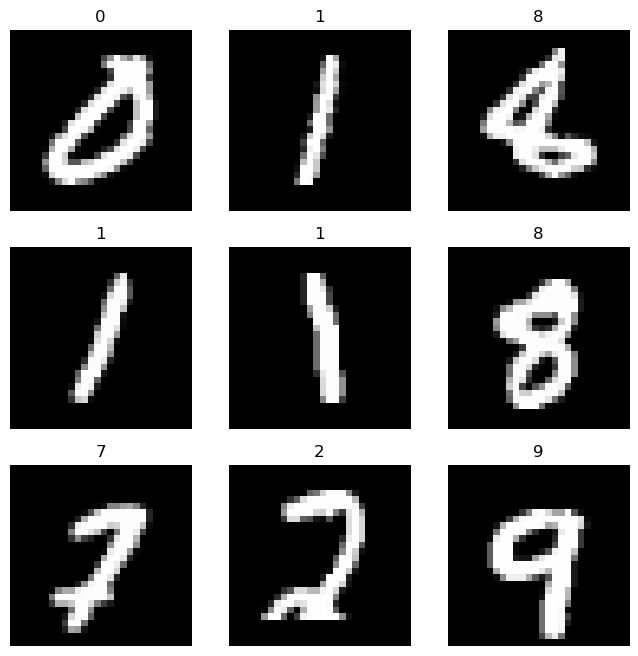

In [6]:
figure = plt.figure(figsize = (8,8))
rows, cols = 3, 3

for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

## Training the neural network

In [7]:
device = (    
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
  )

Getting a random sample and making a prediction before training

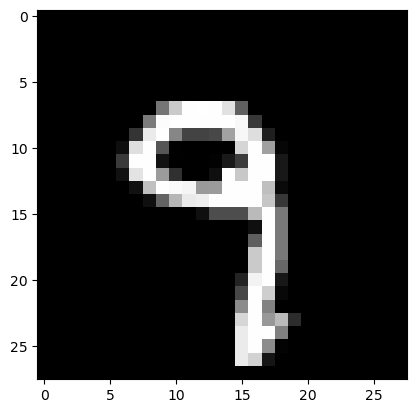

In [8]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
plt.imshow(img.squeeze(), cmap="gray")

In [9]:
model = MnistClassifier().to(device)

output = model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([4])
Actual:  9


Trying to add ReLU to introduce non-linearity

In [10]:
non_linear_model = NonLinearClassifier().to(device)

output = non_linear_model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([4])
Actual:  9


Comparing both models for 50 images

In [11]:
linear_accuracy = 0
non_linear_accuracy = 0

for i in range(0, 50):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  output = model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    linear_accuracy += 1

  output = non_linear_model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    non_linear_accuracy += 1

print("Linear Accuracy: ", linear_accuracy)
print("Non Linear Accuracy: ", non_linear_accuracy)

Linear Accuracy:  5
Non Linear Accuracy:  5


In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [16]:
def train_one_epoch(epoch_index):
  running_loss = 0
  last_loss = 0

  for i, data in enumerate(training_loader):
    inputs, labels = data
    
    # zero gradients
    optimizer.zero_grad()
    
    # compute the prediction
    outputs = model(inputs)
    
    # compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # update the weights
    optimizer.step()

    # gather data and report
    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      # tb_x = epoch_index * len(training_loader) + i + 1
      # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
      running_loss = 0.
  return last_loss
    

In [18]:
# Initializing in a separate cell so we can easily add more epochs to the same run
import datetime


# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# TensorBoard
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
  print('EPOCH {}:'.format(epoch_number + 1))

  # Make sure gradient tracking is on, and do a pass over the data
  model.train(True)
  avg_loss = train_one_epoch(epoch_number)


  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
    for i, vdata in enumerate(testing_loader):
      vinputs, vlabels = vdata
      voutputs = model(vinputs)
      vloss = loss_fn(voutputs, vlabels)
      running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

  # Log the running loss averaged per batch
  # for both training and validation
  # writer.add_scalars('Training vs. Validation Loss',
  #                   { 'Training' : avg_loss, 'Validation' : avg_vloss },
  #                   epoch_number + 1)
  # writer.flush()

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}'.format(epoch_number)
    torch.save(model.state_dict(), model_path)

  epoch_number += 1

EPOCH 1:
LOSS train 0 valid 1.983933925628662
EPOCH 2:
LOSS train 0 valid 1.7020421028137207
EPOCH 3:
LOSS train 0 valid 1.37391996383667
EPOCH 4:


## Testing model